# Gridworld with policy gradient
J'essaie la méthode online policy gradient sur un cas simple.
J'implémente gridword.
L'agent part toujours du meme point et doit atteindre un point qui ne bouge pas au court du temps

In [1]:
import torch.nn as nn
import torch
import numpy as np
from torch import distributions
from IPython.display import clear_output
import time 
import torch.nn.functional
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import matplotlib.pyplot as plt

In [28]:
N  = 5 #réaliser N épisodes
Nx = 8 #longueur de la grille
Ny = 8 #largeur de la grille
Na = 4 #nombres d'actions possibles
actions = [(0,1), (0, -1), (1, 0), (-1, 0)]
R = -1
S = 3
G = 50
beta = .01 
'''
Le parametre Beta permet est la fréquence à laquelle on choisit
d'explorer de manière uniforme une des quatre actions
'''
gamma = .9

On essaie plusieurs récompenses dans les fonctions de transition. Dans la première fonction de transistion, l'agent recoit une récompense de $R = -1$ à chaque pas de temps pour lequel il n'a pas atteint le point final. Et lorsque que l'agent atteint l'objectif il recoit une récompense de $R = 0$. De sorte que l'agent "veuille" atteindre l'objectif le point final le plus rapidement possible

In [3]:
def transition(a,s, Nx, Ny,G):
    assert(0<=s<Nx*Ny)
    d = actions[a]
    s_couple = (s//Ny, s%Ny)
    print('s', s_couple)
    if Nx>s_couple[0]+ d[0]>=0 and Ny>s_couple[1]+d[1]>=0:
        sp = (s_couple[0]+ d[0], s_couple[1]+d[1])
        assert(0<=sp[0]*Ny+sp[1]<Nx*Ny)
        s = sp[0]*Ny+sp[1]  
    R = (s!=G)*(-1) #+ -5*(not (Nx>s_couple[0]+ d[0]>=0 and Ny>s_couple[1]+d[1]>=0))+10*(G==s)
    return s,R

In [4]:
def transition3(a,s, Nx, Ny,G):
    assert(0<=s<Nx*Ny)
    d = actions[a]
    s_couple = (s//Ny, s%Ny)
    print('s', s_couple)
    if Nx>s_couple[0]+ d[0]>=0 and Ny>s_couple[1]+d[1]>=0:
        sp = (s_couple[0]+ d[0], s_couple[1]+d[1])
        assert(0<=sp[0]*Ny+sp[1]<Nx*Ny)
        s = sp[0]*Ny+sp[1]  
    R = (s!=G)*(-1)+ -5*(not (Nx>s_couple[0]+ d[0]>=0 and Ny>s_couple[1]+d[1]>=0))
    return s,R

In [5]:
def transition2(a,s, Nx, Ny,G):
    assert(0<=s<Nx*Ny)
    d = actions[a]
    s_couple = (s//Ny, s%Ny)
    print('s', s_couple)
    if Nx>s_couple[0]+ d[0]>=0 and Ny>s_couple[1]+d[1]>=0:
        sp = (s_couple[0]+ d[0], s_couple[1]+d[1])
        assert(0<=sp[0]*Ny+sp[1]<Nx*Ny)
        s = sp[0]*Ny+sp[1]  
    R = -np.linalg.norm((s_couple[0]+ d[0] - G//Ny, s_couple[1]+d[1] - G%Ny), ord=2)
    return s,R

In [6]:
def zero_one(state,J):
    x = nn.functional.one_hot(state,J)
    x = x.reshape((len(state),-1))
    x = x.type(torch.float32)
    return x

In [7]:
def grid(s, Nx, Ny):
    assert(type(Nx)==int)
    assert(type(Ny)==int)
    assert(type(s)==int)
    assert(0<=s<=Nx*Ny)
    T = np.zeros((Nx,Ny))
    T[G//Ny, G%Ny] = 6
    T[s//Ny, s%Ny] = 1
    print(T)

In [8]:
def tensor_state(s, Nx, Ny):
    state = torch.zeros(Nx*Ny)
    state[s] = 1
    state = state[None, :]
    return state

In [9]:
class policy2(nn.Module):
    def __init__(self, Nx,Ny, Na):
        super(policy2,self).__init__()
        self.Nx = Nx
        self.Ny = Ny
        self.Na = Na
        self.linear1 = nn.Linear(self.Ny*self.Nx,64)
        self.linear2 = nn.Linear(64,32)
        self.linear3 = nn.Linear(32,self.Na)
        self.actv = nn.ReLU()
    def forward(self, x):
        out = self.linear1(x)
        out = self.actv(out)
        out = self.linear2(out)
        out = self.actv(out)
        out = self.linear3(out)
        return out

In [10]:
class policy3(nn.Module):
    def __init__(self, Nx,Ny, Na):
        super(policy3,self).__init__()
        self.Nx = Nx
        self.Ny = Ny
        self.Na = Na
        self.linear1 = nn.Linear(self.Ny*self.Nx,64)
        self.linear2 = nn.Linear(64,32)
        self.linear3 = nn.Linear(32,16)
        self.linear4 = nn.Linear(16,16)
        self.linear5 = nn.Linear(16,self.Na)
        self.actv = nn.ReLU()
    def forward(self, x):
        out = self.linear1(x)
        out = self.actv(out)
        out = self.linear2(out)
        out = self.actv(out)
        out = self.linear3(out)
        out = self.actv(out)
        out = self.linear4(out)
        out = self.actv(out)
        out = self.linear5(out)
        return out

In [11]:
class policy(nn.Module):
    def __init__(self, Nx,Ny, Na):
        super(policy,self).__init__()
        self.Nx = Nx
        self.Ny = Ny
        self.Na = Na
        self.linear1 = nn.Linear(self.Ny*self.Nx,64)
        self.linear2 = nn.Linear(64,self.Na)
        self.actv = nn.ReLU()
        self.softm = nn.Softmax(dim=1)
    def forward(self, x):
        out = self.linear1(x)
        out = self.actv(out)
        out = self.linear2(out)
        #out = self.softm(out) #on utilise softmax pour sortir une probabilité
        return out

In [12]:
def test(p):
    #p is the policy
    i = 0
    s = S
    while True:
        clear_output(wait=True)
        print(i)
        state = tensor_state(s, Nx, Ny)
        out  = p(state)
        dist  = distributions.Categorical(softm(out))
        a = dist.sample([1]) 
        sp = transition(a,s, Nx, Ny)
        grid(sp, Nx, Ny)
        s = sp
        time.sleep(0.05)
        i+=1
        if s==G:
            break
    return i

In [13]:
def train(n_episodes, G,p, transition, lr=0.01):
    optimizer = optim.SGD(p.parameters(), lr=lr)#, momentum=0.9)
    Loss = torch.nn.CrossEntropyLoss(weight = None, reduction = 'none')
    softm = nn.Softmax(dim=1)
    RR = 0
    nombres_iterations = []
    recompense = []
    for n in range(n_episodes):
        s = S
        R_list = []
        States = [S]
        actions_list = []
        out_list = []
        sum_R = 0
        i = 0
        optimizer.zero_grad()
        while True:
            clear_output(wait=True)
            print('n', n+1)
            print(i)
            state = tensor_state(s, Nx, Ny)
            out  = p(state)
            out_list.append(out)
            dist  = distributions.Categorical(softm(out))
            #coder epsilon gridy
            if np.random.binomial(1, beta):
                a = torch.tensor([[np.random.randint(0,Na)]])
            else:
                a = dist.sample([1])
            actions_list.append(a.numpy()[0][0])  
            sp,R = transition(a,s, Nx, Ny, G)
            grid(sp, Nx, Ny)
            s = sp
            States.append(s)
            print('reward previous ep', RR)
            time.sleep(0.05)
            i+=1
            R_list.append(R)
            if sp==G:
                break
        T = torch.tensor([sum(R_list[i:])for i in range(len(R_list))]).type(torch.float32)
        T = (T - torch.mean(T))/torch.std(T)
        out_p = pad_sequence(out_list)
        actions_tens = zero_one(torch.tensor(actions_list),Na)
        loss = Loss(out_p[0],actions_tens)
        RR =sum(R_list)
        recompense.append(RR)
        nombres_iterations.append(i)
        PseudoLoss_w = torch.multiply(loss,T)
        #print(PseudoLoss_w)
        NegativPseudoLoss = torch.sum(PseudoLoss_w)
        #calcul du gradient de la pseudoloss
        NegativPseudoLoss.backward()
        #On maximise la pseudo loss en minimisant son oppose
        optimizer.step()
    return recompense, nombres_iterations

In [14]:
Policy = policy2(Nx,Ny,Na)

In [15]:
c,iterr = train(2000, G,Policy, transition, 0.01)

n 2000
6
s (5, 2)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
reward previous ep -6


8.165


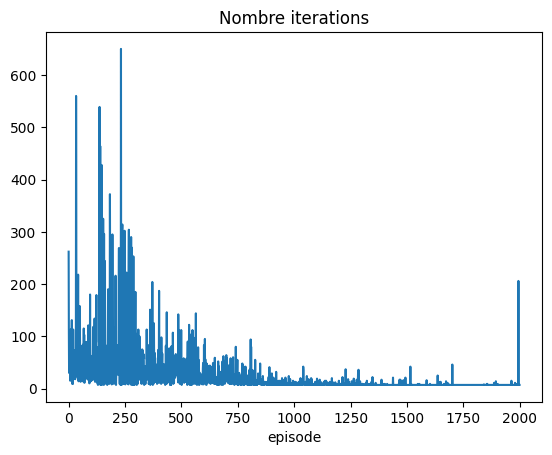

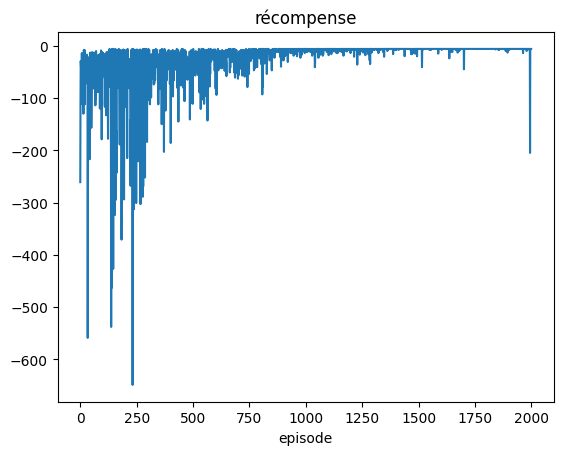

In [17]:
plt.plot(iterr)
plt.title('Nombre iterations')
plt.xlabel('episode')
plt.show()
plt.plot(c)
plt.title('récompense')
plt.xlabel('episode')
plt.show()

In [20]:
print(np.mean(iterr[1800:]))

8.165


La polique semble avoir "convergé", ou presque car la récompense smeble est maximisée. En moyenne sur les derniers episodes, il faut 8 iterrations pour que l'agent termine l'épisode. On pourra tenter de mettre un facteur d'escompte dans la somme des récompenses. L'approche faite ici est la version "online" de la méthode policy gradient. Il est interréssant de tenter une approche "offline", dans laquelle on aura pas besoin qu'un episode termine pour actualiser la politique